---

# Ensembles of models

In this assignment, we will consider the application of some classical and well-proven ensemble algorithms. We will demonstrate the work of these algorithms using electricity consumption dataset.

# Dataset description

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends). 

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Exploratory data analysis

Read the dataset into a dataframe

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

df = pd.read_csv('electricity_train.csv')

Use the <code>.describe()</code> method to explore the dataset "from a bird's eye view".

In [4]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Make sure there are no missing values. It makes sense to check the balance of classes. Enter the proportion of elements of the class $1$.

In [6]:
NAs = df.isna().sum()
NAs

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

In [7]:
total_elements = len(df)
 

class_one_elements = np.sum(df["class"] == 1)
proportion = (class_one_elements / total_elements)
proportion

np.float64(0.4245358492648073)

Construct a correlation matrix. Identify the pair of most correlated features.

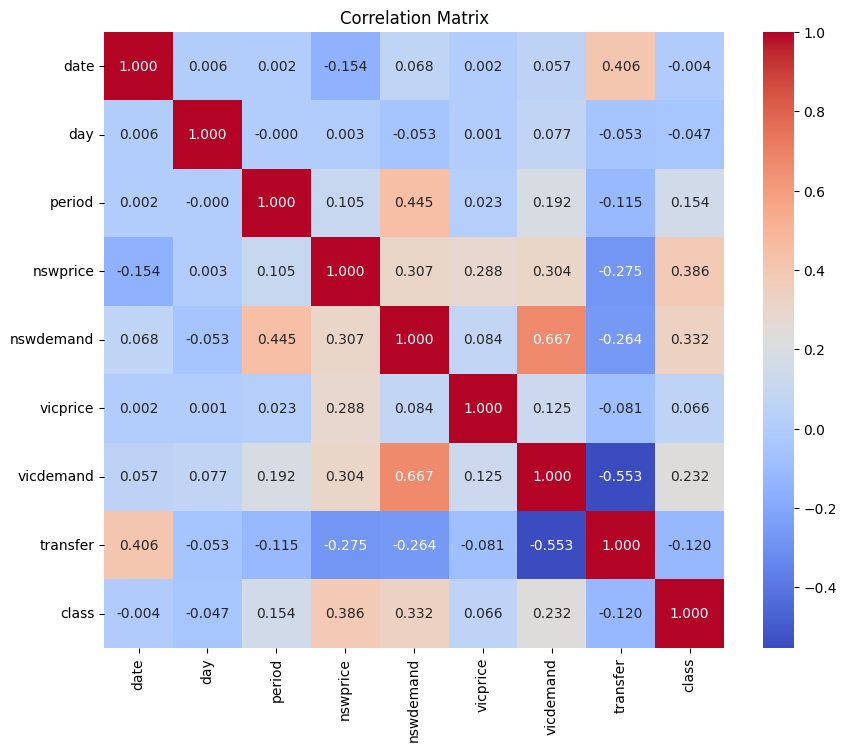

In [9]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title(f'Correlation Matrix')
plt.show()

In [10]:
corr_matrix = corr_matrix.abs()  # Use absolute values for positive/negative correlation


# Find the maximum correlation (excluding diagonal)
max_corr = 0
most_correlated_pair = None
for i in range(len(corr_matrix)):
     for j in range(i + 1, len(corr_matrix)):
        feature1 = corr_matrix.index[i]
        feature2 = corr_matrix.columns[j]
        correlation = corr_matrix.iloc[i, j]

        if correlation > max_corr:
            max_corr = correlation
            most_correlated_pair = (feature1, feature2, correlation)
most_correlated_pair

('nswdemand', 'vicdemand', np.float64(0.6671743250710647))

Construct histograms of the distributions of the features.

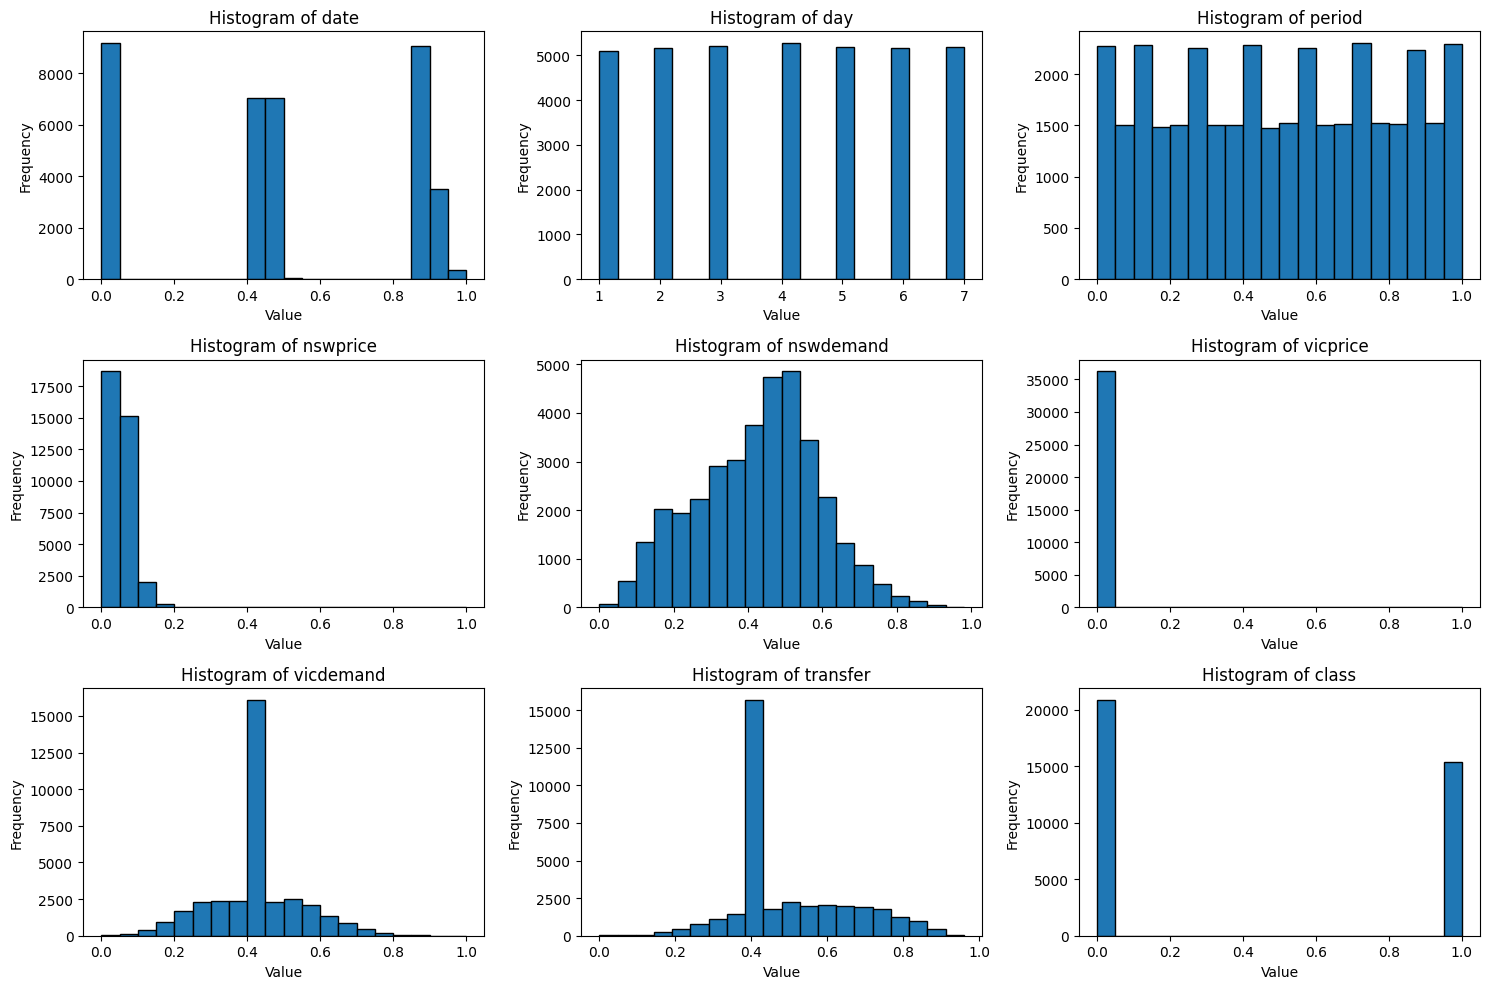

In [12]:
predictor_columns = df.columns.tolist()
num_predictors = len(predictor_columns)
num_cols = 3  # You can adjust the number of columns for the subplots
num_rows = (num_predictors + num_cols - 1) // num_cols

plt.figure(figsize=(15, 10))

for i, col in enumerate(predictor_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(df[col], bins=20, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From the resulting illustrations, we can see that there is probably some periodicity in the data, as expected. Moreover, it seems that the missing values and outlier processing has already been done for us.

Use <code>train_test_split</code> to split the resulting dataset into training and test samples with the parameters specified in your individual assignment.

In [2]:
X = df.drop(columns=['class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Random Forests Classifier

Train the <code>sklearn.ensemble.RandomForestClassifier</code> model on the training dataset with the parameters specified in your individual assignment.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
model_forest = RandomForestClassifier(random_state=3)
model_forest.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model_forest.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred)
accuracy

1.0

Build the <code>classification_report</code> of the resulting model on **training dataset**. Enter the accuracy of the model on the **training dataset**.

In [20]:
report = classification_report(y_train, y_train_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     16728
           1      1.000     1.000     1.000     12271

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



We got overfitting. Well, once again, we can answer that decision trees are quite prone to overtraining.

## Adding GridSearchCV to the Random Forest.

Using the <code>sklearn.model_selection.GridSearchCV</code>, train <code>RandomForestClassifier</code> on training dataset with the parameters specified in your individual assignment.

In [22]:
from sklearn.model_selection import GridSearchCV
params_grid = {'n_estimators': [100,300,500],
  'max_leaf_nodes': list(range(6,10)),
  'min_samples_leaf': [1,2,3]}

grid_search = GridSearchCV(RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=3),
    params_grid,
    verbose=4,
    cv=3)

Select the best model. We recommend using the field <code>best_estimator_</code> of the <code>grid_search</code> class object. We can find the parameters of the best model in the field <code>best_params_</code> of this object.

In [25]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.773 total time=   0.5s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.767 total time=   0.4s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.777 total time=   0.4s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   1.4s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.769 total time=   1.5s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.778 total time=   1.6s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.773 total time=   2.5s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.768 total time=   2.6s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.777 total time=   2.6s
[CV 1/3] END max_leaf_nodes=6

c:\Python\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=3),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

In [28]:
grid_search.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 500}

Build the <code>classification_report</code> of the resulting model on the **training dataset**.
Enter the model accuracy on the **training dataset**.

In [9]:
model_forest = RandomForestClassifier(random_state=3, max_leaf_nodes = 9, min_samples_leaf = 1, n_estimators = 500)
model_forest.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model_forest.predict(X_train)

# Evaluate the model
report = classification_report(y_train, y_train_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7527    0.9022    0.8207     16728
           1     0.8172    0.5959    0.6892     12271

    accuracy                         0.7726     28999
   macro avg     0.7849    0.7490    0.7549     28999
weighted avg     0.7800    0.7726    0.7650     28999



In [15]:
model_forest.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(max_leaf_nodes=9, n_estimators=500, random_state=3)>

Build the <code>classification_report</code> of the resulting model on the **test dataset**.
Enter the model accuracy on the **test dataset**.

In [8]:
# Make predictions on the training data
y_test_pred = model_forest.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_test_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7527    0.9066    0.8225      4132
           1     0.8302    0.6052    0.7001      3118

    accuracy                         0.7770      7250
   macro avg     0.7914    0.7559    0.7613      7250
weighted avg     0.7860    0.7770    0.7698      7250



Overfitting has been avoided, but accuracy seems low.

One of the advantages of random forest is that you can look at the importance of features when classifying (inverse problem). Importance values can be found in the field <code>feature_importances_</code> of the model. Identify the name of the most important feature of the model.

In [35]:
model_forest.feature_importances_
#max importance - nswprice

array([0.04933629, 0.01181289, 0.11283075, 0.47734331, 0.12156926,
       0.18483936, 0.03347639, 0.00879175])

Let's try to improve the results by using other types of ensembles.

# Voting Classifier

Trains all models given as input and predicts the final result either by the greater number of identical answers that the models gave (hard), or calculates the probability of assigning objects to classes across all models and takes argmax.

Use an <code>sklearn.ensemble.VotingClassifier</code> object with the parameter <code>voting='hard'</code>. Use classifiers with the appropriate parameters specified in your individual assignment as base algorithms. Train the model on the training dataset.

In [36]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
estimators = [('lr', LogisticRegression(solver='liblinear', random_state=3)),
        ('svc', SVC(random_state=3)),
        ('sgd', SGDClassifier(random_state=3))
    ]

model_voting = VotingClassifier(estimators=estimators, voting="hard")

Enter the model accuracy on the **training dataset**.

In [38]:
model_voting.fit(X_train, y_train)
# Make predictions on the training data
y_train_pred = model_voting.predict(X_train)

# Evaluate the model
report = classification_report(y_train, y_train_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.732     0.905     0.809     16728
           1      0.809     0.547     0.653     12271

    accuracy                          0.754     28999
   macro avg      0.770     0.726     0.731     28999
weighted avg      0.764     0.754     0.743     28999



Enter the model accuracy on the **test dataset**.

In [40]:
# Make predictions on the training data
y_test_pred = model_voting.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_test_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.727     0.907     0.807      4132
           1      0.817     0.549     0.657      3118

    accuracy                          0.753      7250
   macro avg      0.772     0.728     0.732      7250
weighted avg      0.766     0.753     0.743      7250



# Bagging Classifier

Creates multiple objects of the same class (multiple models) and trains them on non-overlapping subsets of the training dataset, and further averages the predictions.

Based on <code>sklearn.ensemble.BaggingClassifier</code>, using <code>DecisionTreeClassifier</code> train the model on the training dataset with the parameters specified in your individual assignment.

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
model_bagging = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'),max_samples=0.5, max_features=0.5,bootstrap=False,random_state=3)

model_bagging.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_features=0.5, max_samples=0.5, random_state=3)

Enter the model accuracy on the **training dataset**.

In [43]:
# Make predictions on the training data
y_train_pred = model_bagging.predict(X_train)

# Evaluate the model
report = classification_report(y_train, y_train_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.969     0.993     0.981     16728
           1      0.991     0.956     0.973     12271

    accuracy                          0.978     28999
   macro avg      0.980     0.975     0.977     28999
weighted avg      0.978     0.978     0.978     28999



Enter the model accuracy on the **test dataset**.

In [17]:
# Make predictions on the training data
y_test_pred = model_bagging.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_test_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.815     0.910     0.860      4132
           1      0.860     0.726     0.787      3118

    accuracy                          0.831      7250
   macro avg      0.837     0.818     0.824      7250
weighted avg      0.834     0.831     0.829      7250



# Gradient Boosting Classifier

Gradient boosting works like this: several objects of a class (several models) are created, they are chained so that each next one tries to correct the errors of the previous one. Prone to overlearning.

Train a model based on <code>sklearn.ensemble.GradientBoostingClassifier</code> on training dataset with the parameters specified in your individual assignment.

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
model_gradient = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=3, max_depth=2)
model_gradient.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.8, max_depth=2, n_estimators=500,
                           random_state=3)

Enter the model accuracy on the **training dataset**.

In [46]:
# Make predictions on the training data
y_train_pred = model_gradient.predict(X_train)

# Evaluate the model
report = classification_report(y_train, y_train_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.936     0.945     0.940     16728
           1      0.924     0.912     0.918     12271

    accuracy                          0.931     28999
   macro avg      0.930     0.928     0.929     28999
weighted avg      0.931     0.931     0.931     28999



Enter the model accuracy on the **test dataset**.

In [47]:
# Make predictions on the training data
y_test_pred = model_gradient.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_test_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.908     0.915     0.912      4132
           1      0.886     0.878     0.882      3118

    accuracy                          0.899      7250
   macro avg      0.897     0.896     0.897      7250
weighted avg      0.899     0.899     0.899      7250



# AdaBoost Classifier

It works in a similar way to gradient boosting, however subsequent models do not try to correct the error of the previous ones: the first object is trained on the entire dataset, and the next one updates its weights based on the experience of the previous one in a way that corrects erroneous predictions.

Based on <code>sklearn.ensemble.AdaBoostClassifier</code>, using <code>DecisionTreeClassifier</code>, train the model with the parameters specified in your individual assignment on the training dataset.

In [18]:
from sklearn.ensemble import AdaBoostClassifier
model_Ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=3)
model_Ada.fit(X_train, y_train)

c:\Python\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   learning_rate=0.5, n_estimators=300, random_state=3)

Enter the model accuracy on the **training dataset**.

In [49]:
# Make predictions on the training data
y_train_pred = model_Ada.predict(X_train)

# Evaluate the model
report = classification_report(y_train, y_train_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.958     0.937     0.947     16728
           1      0.916     0.945     0.930     12271

    accuracy                          0.940     28999
   macro avg      0.937     0.941     0.939     28999
weighted avg      0.941     0.940     0.940     28999



Enter the model accuracy on the **test dataset**.

In [19]:
# Make predictions on the training data
y_test_pred = model_Ada.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_test_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.925     0.898     0.911      4132
           1      0.870     0.904     0.887      3118

    accuracy                          0.901      7250
   macro avg      0.898     0.901     0.899      7250
weighted avg      0.901     0.901     0.901      7250



# Stacking Classifier

Trains multiple class objects (multiple models) on the entire dataset, and then trains a separate classifier on the metdata - the predictions obtained by the previously trained models.

Use the <code>sklearn.ensemble.StackingClassifier</code> object. The basic algorithms and solver, as well as the corresponding parameters, are specified in your individual assignment. Train the model on the training dataset.

In [51]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(random_state=3)),
    ('svc', SVC(random_state=3))
]
final_estimator = LogisticRegression(random_state=3)
model_stacking = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
model_stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=3)),
                               ('svc', SVC(random_state=3))],
                   final_estimator=LogisticRegression(random_state=3))

Enter the model accuracy on the **training dataset**.

In [52]:
# Make predictions on the training data
y_train_pred = model_stacking.predict(X_train)

# Evaluate the model
report = classification_report(y_train, y_train_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     16728
           1      1.000     1.000     1.000     12271

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Enter the model accuracy on the **test dataset**.

In [53]:
# Make predictions on the training data
y_test_pred = model_stacking.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_test_pred, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.911     0.921     0.916      4132
           1      0.894     0.881     0.887      3118

    accuracy                          0.904      7250
   macro avg      0.902     0.901     0.901      7250
weighted avg      0.903     0.904     0.903      7250

